In [1]:
from google.colab import files
uploaded = files.upload()

Saving audio.wav to audio.wav


In [2]:
from scipy.io import wavfile
sample_rate, data = wavfile.read('audio.wav')

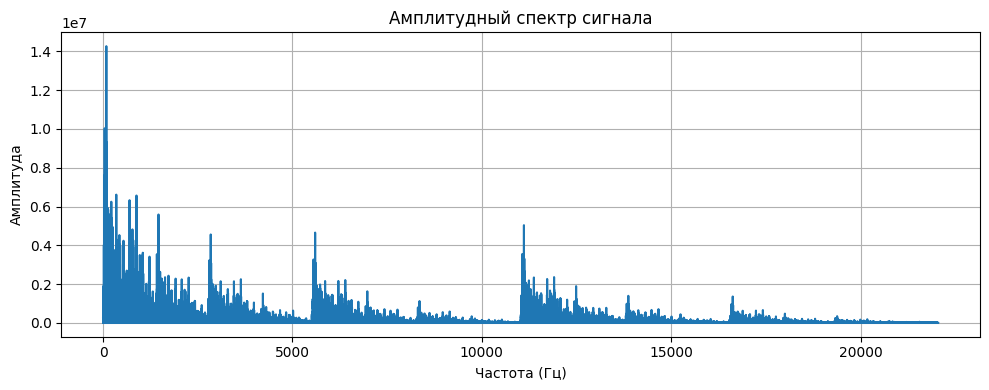

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile

def iterative_fft(x):
    x = np.asarray(x, dtype=complex)
    N = x.shape[0]
    levels = int(np.log2(N))
    assert 2**levels == N, "Длина сигнала должна быть степенью двойки"

    indices = np.arange(N)
    indices = indices.reshape((N, 1))
    bits = np.arange(levels)
    rev_indices = ((indices & (1 << bits)) > 0).astype(int)
    rev_indices = rev_indices[:, ::-1]
    rev_indices = rev_indices.dot(1 << np.arange(levels))
    x = x[rev_indices]

    size = 2
    while size <= N:
        half = size // 2
        exp_term = np.exp(-2j * np.pi * np.arange(half) / size)
        for i in range(0, N, size):
            temp = x[i:i+half]
            x[i:i+half] = temp + exp_term * x[i+half:i+size]
            x[i+half:i+size] = temp - exp_term * x[i+half:i+size]
        size *= 2
    return x

rate, data = wavfile.read("audio.wav")
if data.ndim > 1:
    data = data[:, 0]

N = len(data)
if np.log2(N) % 1 != 0:
    N_pow2 = 2**int(np.floor(np.log2(N)))
    data = data[:N_pow2]
    N = N_pow2

fft_data = iterative_fft(data)
frequencies = np.fft.fftfreq(N, d=1/rate)

cutoff = 1000

fft_low = np.where(np.abs(frequencies) < cutoff, fft_data, 0)
low_filtered = np.fft.ifft(fft_low).real.astype(np.int16)
wavfile.write("low_frequencies.wav", rate, low_filtered)

fft_high = np.where(np.abs(frequencies) > cutoff, fft_data, 0)
high_filtered = np.fft.ifft(fft_high).real.astype(np.int16)
wavfile.write("high_frequencies.wav", rate, high_filtered)

plt.figure(figsize=(10, 4))
plt.plot(frequencies[:N//2], np.abs(fft_data[:N//2]))
plt.title("Амплитудный спектр сигнала")
plt.xlabel("Частота (Гц)")
plt.ylabel("Амплитуда")
plt.grid()
plt.tight_layout()
plt.show()
